## Imports

In [2]:
import torch
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import itertools
import tqdm
import matplotlib
import matplotlib.pyplot as plt
import random

import vr.utils as utils
from vr.preprocess import tokenize, encode
import argparse
import sys
from scipy.misc import imread, imresize

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Constants

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--program_generator', default='models/best.pt')
parser.add_argument('--execution_engine', default='models/best.pt')
parser.add_argument('--baseline_model', default=None)
parser.add_argument('--model_type', default='FiLM')
parser.add_argument('--debug_every', default=float('inf'), type=float)
parser.add_argument('--use_gpu', default=1, type=int)

# For running on a preprocessed dataset
parser.add_argument('--input_question_h5', default=None)
parser.add_argument('--input_features_h5', default=None)

# This will override the vocab stored in the checkpoint;
# we need this to run CLEVR models on human data
parser.add_argument('--vocab_json', default=None)

# For running on a single example
parser.add_argument('--question', default=None)
parser.add_argument('--question_file', default=None)
parser.add_argument('--image', default='img/CLEVR_val_000017.png')
parser.add_argument('--cnn_model', default='resnet101')
parser.add_argument('--cnn_model_stage', default=3, type=int)
parser.add_argument('--image_width', default=224, type=int)
parser.add_argument('--image_height', default=224, type=int)
parser.add_argument('--enforce_clevr_vocab', default=1, type=int)

parser.add_argument('--batch_size', default=64, type=int)
parser.add_argument('--num_samples', default=None, type=int)
parser.add_argument('--num_last_words_shuffled', default=0, type=int)  # -1 for all shuffled
parser.add_argument('--family_split_file', default=None)

parser.add_argument('--sample_argmax', type=int, default=1)
parser.add_argument('--temperature', default=1.0, type=float)

# FiLM models only
parser.add_argument('--gamma_option', default='linear',
  choices=['linear', 'sigmoid', 'tanh', 'exp', 'relu', 'softplus'])
parser.add_argument('--gamma_scale', default=1, type=float)
parser.add_argument('--gamma_shift', default=0, type=float)
parser.add_argument('--gammas_from', default=None)  # Load gammas from file
parser.add_argument('--beta_option', default='linear',
  choices=['linear', 'sigmoid', 'tanh', 'exp', 'relu', 'softplus'])
parser.add_argument('--beta_scale', default=1, type=float)
parser.add_argument('--beta_shift', default=0, type=float)
parser.add_argument('--betas_from', default=None)  # Load betas from file

# If this is passed, then save all predictions to this file
parser.add_argument('--output_h5', default=None)
parser.add_argument('--output_preds', default=None)
parser.add_argument('--output_viz_dir', default='img/')
parser.add_argument('--output_program_stats_dir', default=None)
parser.add_argument('--distill_viz', default=True, type=int)

sys.argv = []
args = parser.parse_args()

## Build Model

In [4]:
def extract_image_features(cnn, filename, width=224, height=224, dtype=torch.FloatTensor):
  # Build the CNN to use for feature extraction
  # Load and preprocess the image
  img_size = (height, width)
  img = imread(filename, mode='RGB')
  img = imresize(img, img_size, interp='bicubic')
  img = img.transpose(2, 0, 1)[None]
  mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
  std = np.array([0.229, 0.224, 0.224]).reshape(1, 3, 1, 1)
  img = (img.astype(np.float32) / 255.0 - mean) / std

  # Use CNN to extract features for the image
  img_var = Variable(torch.FloatTensor(img).type(dtype), volatile=False, requires_grad=True)
  img_var = img_var.to(device)  
  feats_var = cnn(img_var)
  return feats_var

def build_cnn(args, dtype):
  if not hasattr(torchvision.models, args.cnn_model):
    raise ValueError('Invalid model "%s"' % args.cnn_model)
  if not 'resnet' in args.cnn_model:
    raise ValueError('Feature extraction only supports ResNets')
  whole_cnn = getattr(torchvision.models, args.cnn_model)(pretrained=True)
  layers = [
    whole_cnn.conv1,
    whole_cnn.bn1,
    whole_cnn.relu,
    whole_cnn.maxpool,
  ]
  for i in range(args.cnn_model_stage):
    name = 'layer%d' % (i + 1)
    layers.append(getattr(whole_cnn, name))
  cnn = torch.nn.Sequential(*layers)
  cnn.type(dtype)
  cnn.eval()
  return cnn

pg, _ = utils.load_program_generator(args.program_generator, args.model_type)
ee, _ = utils.load_execution_engine(args.execution_engine, verbose=False, model_type=args.model_type)
model = (pg.to(device), ee.to(device))

dtype = torch.cuda.FloatTensor
cnn = build_cnn(args, dtype).to(device)

Loading FiLMGen from models/best.pt


/workspace/film/vr/models/layers.py:141: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init_params(m.weight)


Loading FiLMedNet from models/best.pt


## Process question/image pairs

In [5]:
def get_norms(features):
    fmap_norms = (features ** 2).sum(-1).sum(-1).sqrt()
    norms = fmap_norms.data.squeeze()
    return norms

grads = {}
def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook


def run_single_example(model, dtype, question_var, feats_var):
    # Run the model
    scores = None
    predicted_program = None
    pg, ee = model
    pg.type(dtype)
    pg.eval()
    ee.type(dtype)
    ee.eval()

    predicted_program = pg(question_var)
    scores = ee(feats_var, predicted_program, save_activations=True)

    # Print results
    predicted_probs = scores.data.cpu()
    _, predicted_answer_idx = predicted_probs[0].max(dim=0)
    predicted_probs = F.softmax(Variable(predicted_probs[0])).data
    predicted_answer = vocab['answer_idx_to_token'][predicted_answer_idx.item()]

    answers_to_probs = {}
    for i in range(len(vocab['answer_idx_to_token'])):
        answers_to_probs[vocab['answer_idx_to_token'][i]] = predicted_probs[i]
        answers_to_probs_sorted = sorted(answers_to_probs.items(), key=lambda x: x[1])
        answers_to_probs_sorted.reverse()

    gammas, betas = torch.split(predicted_program[:,:,:2*128], 128, dim=-1)
    relu_out, pre_film = zip(*ee.module_outputs)
    pre_film = get_norms(torch.stack(pre_film))
    relu_norms = get_norms(torch.stack(relu_out))
    
    # Get gradients
    for i in range(ee.num_modules):
        ee.module_outputs[i][0].register_hook(save_grad('m' + str(i)))
    
    probs = F.softmax(scores[0])
#     entropy = -(probs * probs.log()).sum()
#     entropy.backward()
#     module_grads = torch.stack([grads['m' + str(i)] for i in range(4)], dim=1)
#     module_grad_norms = get_norms(module_grads)
    
    data = {
        'question': question_var.cpu().numpy(),
        'answer': predicted_answer,
        'relu_norms': relu_norms.cpu().numpy().flatten(),
        'pre_film_norms': pre_film.cpu().numpy().flatten(),
        'gammas': gammas.cpu().detach().numpy().flatten(),
        'betas': betas.cpu().detach().numpy().flatten(),
#         'film_grad_norms': module_grad_norms.numpy().flatten(),
    }
    return data

def run_raw(question_raw, img_name):
    question_tokens = tokenize(question_raw,
                      punct_to_keep=[';', ','],
                      punct_to_remove=['?', '.'])
    question_encoded = encode(question_tokens,
                       vocab['question_token_to_idx'],
                       allow_unk=True)
    question_encoded = torch.LongTensor(question_encoded).view(1, -1)
    question_encoded = question_encoded.type(dtype).long()
    question_var = Variable(question_encoded, volatile=False)
    feats_var = extract_image_features(cnn, content_img).detach()
    return run_single_example(model, dtype, question_var, feats_var)

In [6]:
import h5py

q_feats = h5py.File('data/val_questions.h5', 'r')
img_feats = h5py.File('data/val_features.h5', 'r')
vocab = utils.load_cpu('models/best.pt')['vocab']

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
CONTENT_IMAGES = [
    'img/CLEVR_val_000010.png',
    'img/CLEVR_val_000011.png',
    'img/CLEVR_val_000012.png',
    'img/CLEVR_val_000013.png'
]

with open('data/questions.txt', 'r') as myfile: QUESTIONS = myfile.read().splitlines()

QUESTIONS_SMALL = QUESTIONS[:4]
CONTENT_KEYS = list(itertools.product(CONTENT_IMAGES, QUESTIONS[0:1]))
SMALL_KEYS = list(itertools.product(CONTENT_IMAGES, QUESTIONS_SMALL))
ALL_KEYS = list(itertools.product(CONTENT_IMAGES, QUESTIONS))
QUESTION_KEYS = list(itertools.product(CONTENT_IMAGES[0:1], QUESTIONS))
QUESTION_KEYS_SMALL = list(itertools.product(CONTENT_IMAGES[0:1], QUESTIONS_SMALL))

In [8]:
question = "How many green cubes are there?"
content_img = "img/CLEVR_val_000010.png"

data = {}
for content_img in CONTENT_IMAGES:
    for question in tqdm.tqdm(QUESTIONS):
        sample = run_raw(question, content_img)
        data[(content_img, question)] = sample

  0%|          | 0/104 [00:00<?, ?it/s]__main__:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
__main__:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
__main__:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
__main__:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 104/104 [00:04<00:00, 21.00it/s]


## Analysis

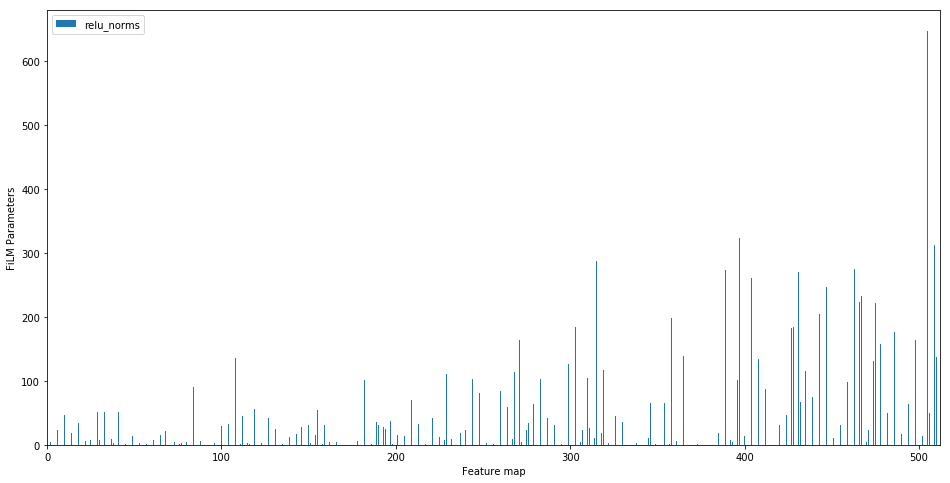

In [9]:
SINGLE_EXAMPLE_KEY = CONTENT_KEYS[0]
ALL_KEYS = data.keys()

fig, ax = plt.subplots(figsize=(16, 8))
keys = ['relu_norms']
xs = np.asarray(
 [np.copy(data[SINGLE_EXAMPLE_KEY][key]) for key in keys]
)
ax.set_xlim([0, xs.shape[-1]])
ax.set_xlabel('Feature map')
ax.set_ylabel('FiLM Parameters')
width = 0.2
offset = width
ind = np.arange(xs.shape[-1])
for i, (x, k) in enumerate(zip(xs, keys)):
    ax.bar(ind + i * offset, x, width, label=k)
    _ = ax.legend()

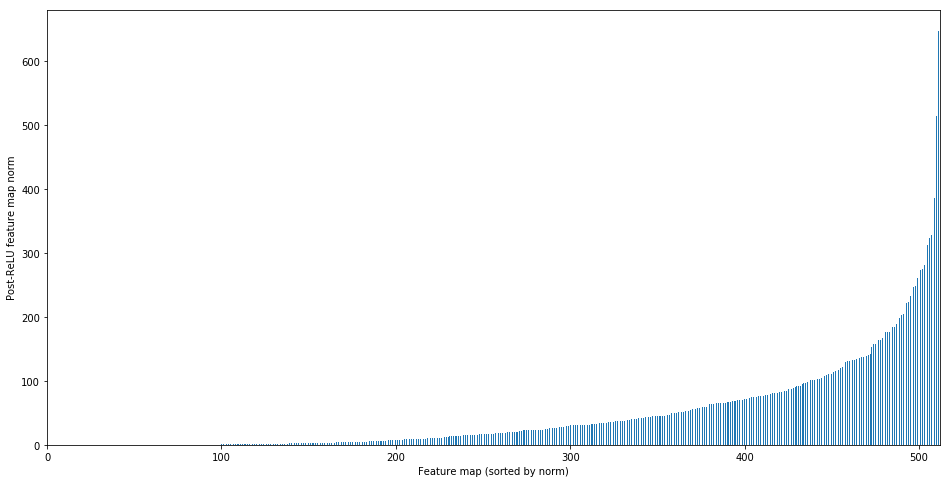

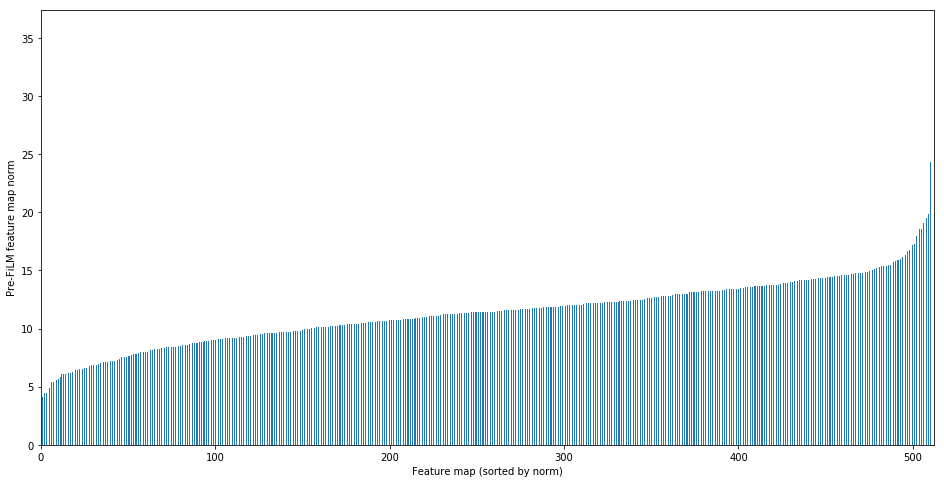

In [10]:
x = np.copy(data[SINGLE_EXAMPLE_KEY]['relu_norms'])
x.sort()
ind = np.arange(len(x))
width = 0.45
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(ind, x, width)
ax.set_xlim([0, len(x)])
ax.set_xlabel('Feature map (sorted by norm)')
_ = ax.set_ylabel('Post-ReLU feature map norm')

x = np.copy(data[SINGLE_EXAMPLE_KEY]['pre_film_norms'])
x.sort()
ind = np.arange(len(x))
width = 0.45
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(ind, x, width)
ax.set_xlim([0, len(x)])
ax.set_xlabel('Feature map (sorted by norm)')
_ = ax.set_ylabel('Pre-FiLM feature map norm')

#### Multiple Content Images/Single Question

How are FiLM-ed residual blocks influenced by the underlying content information?

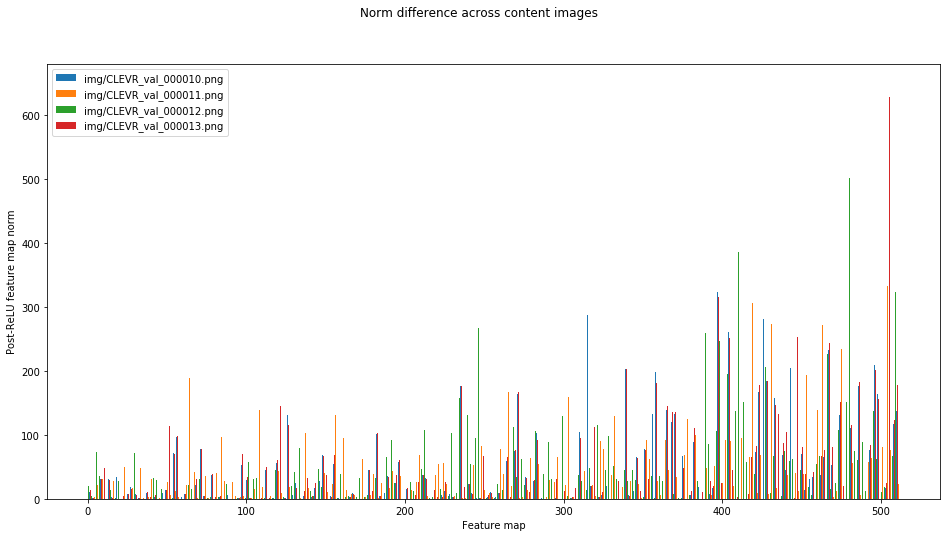

In [11]:
low, high = 0, 512
KEYS = CONTENT_KEYS

fig, ax = plt.subplots(figsize=(16, 8))
fig.suptitle("Norm difference across content images")
ax.set_xlabel('Feature map')
ax.set_ylabel('Post-ReLU feature map norm')
width = 0.2
offset = width
ind = np.arange(low, high)

xs = np.asarray(
 [np.copy(data[key]['relu_norms'])[low:high] for key in KEYS]
)

for i, (x, content_name) in enumerate(zip(xs, CONTENT_IMAGES)):
    _ = ax.bar(ind + i * offset, x, width, label=content_name)
    _ = ax.legend()

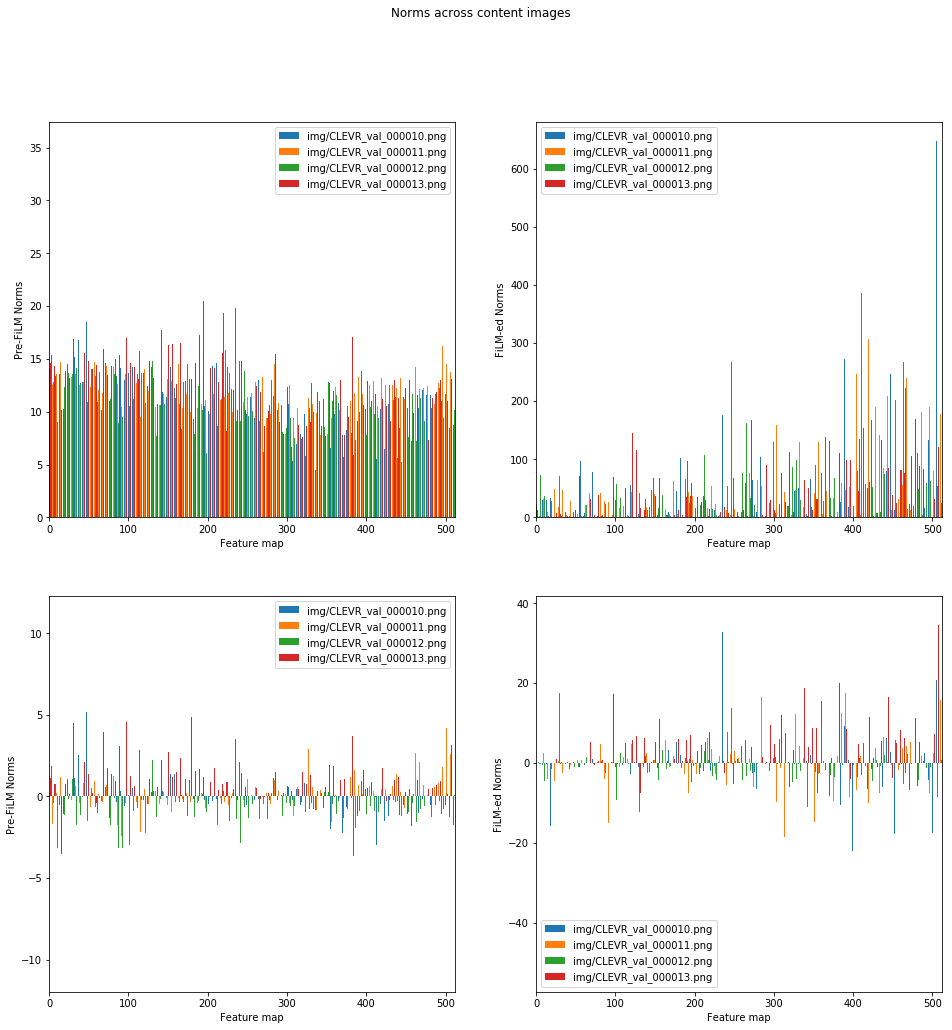

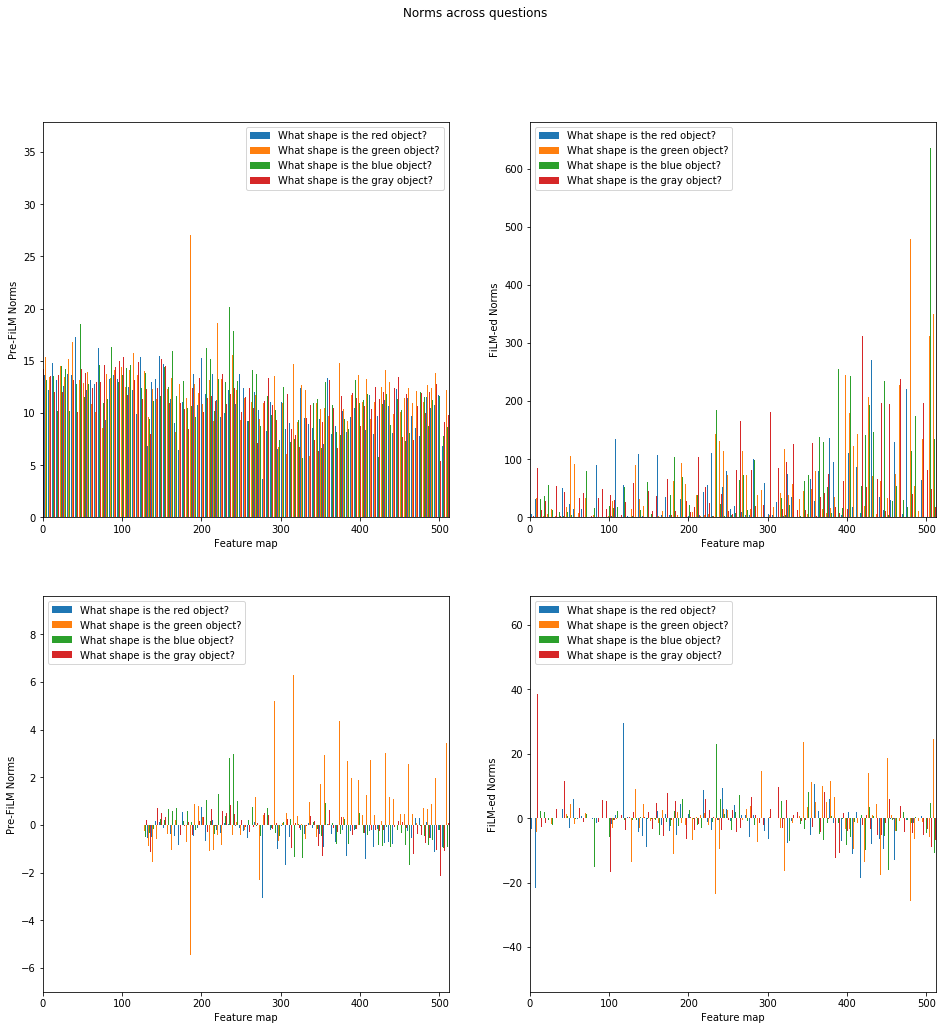

In [12]:
low, high = 0, 512
width = 0.2
offset = width
ind = np.arange(low, high)

for KEYS, LABELS, title in [(CONTENT_KEYS, CONTENT_IMAGES, "Norms across content images"), (QUESTION_KEYS_SMALL, QUESTIONS_SMALL, "Norms across questions")]:
    fig, rows = plt.subplots(2, 2, figsize=(16, 16))
    fig.suptitle(title)
    
    bn_norm = np.asarray(
     [np.copy(data[key]["pre_film_norms"])[low:high] for key in KEYS]
    )

    filmed_norm = np.asarray(
     [np.copy(data[key]["relu_norms"])[low:high] for key in KEYS]
    )
    
    bn_norm_shifted = bn_norm - bn_norm.mean(axis=0, keepdims=True)
    filmed_norm_shifted = filmed_norm - filmed_norm.mean(axis=0, keepdims=True)

    plots = [
        [(bn_norm, 'Pre-FiLM Norms'), (filmed_norm, 'FiLM-ed Norms')],
        [(bn_norm_shifted, 'Pre-FiLM Norms'), (filmed_norm_shifted, 'FiLM-ed Norms')]
    ]
    for row, norms in zip(rows, plots):
        for ax, (xs, label) in zip(row, norms):
            ax.set_xlim([low, high])
            ax.set_xlabel('Feature map')
            ax.set_ylabel(label)

            for i, (x, content_name) in enumerate(zip(xs, LABELS)):
                _ = ax.bar(ind + i * offset, x, width, label=content_name)
                _ = ax.legend()


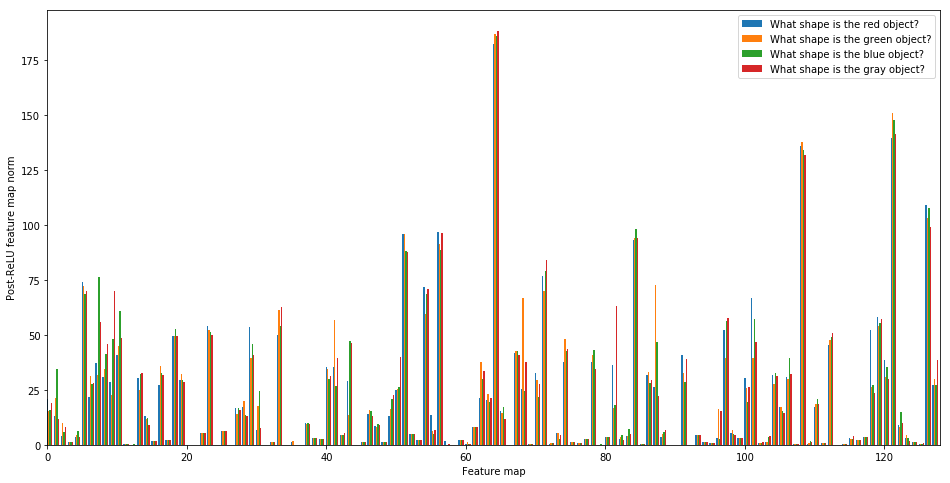

In [13]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_xlim([0, 128])
ax.set_xlabel('Feature map')
ax.set_ylabel('Post-ReLU feature map norm')
width = 0.2
offset = width
ind = np.arange(128)
xs = np.asarray(
 [np.copy(data[key]['relu_norms'])[:128] for key in SMALL_KEYS]
).reshape((4, 4, -1)).mean(axis=0)
for i, (x, question) in enumerate(zip(xs, QUESTIONS_SMALL)):
    ax.bar(ind + i * offset, x, width, label=question)
    _ = ax.legend()

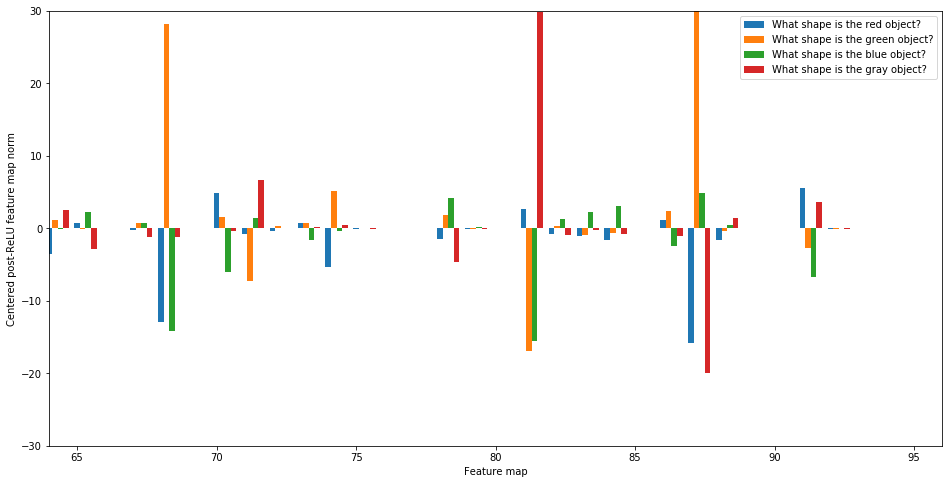

In [14]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_xlim([64, 96])
ax.set_ylim([-30, 30])
ax.set_xlabel('Feature map')
ax.set_ylabel('Centered post-ReLU feature map norm')
width = 0.2
offset = width
ind = np.arange(64, 96)
xs = np.asarray(
 [np.copy(data[key]['relu_norms'])[64:96] for key in SMALL_KEYS]
).reshape((len(CONTENT_IMAGES), len(QUESTIONS_SMALL), -1)).mean(axis=0)
xs = xs - xs.mean(axis=0, keepdims=True)
for i, (x, style_name) in enumerate(zip(xs, QUESTIONS_SMALL)):
    ax.bar(ind + i * offset, x, width, label=style_name)
_ = ax.legend()

#### Pre-ReLU norm vs. Post-FiLM norm coloured by question type (how, what, etc.)

### Gamma/Beta analysis

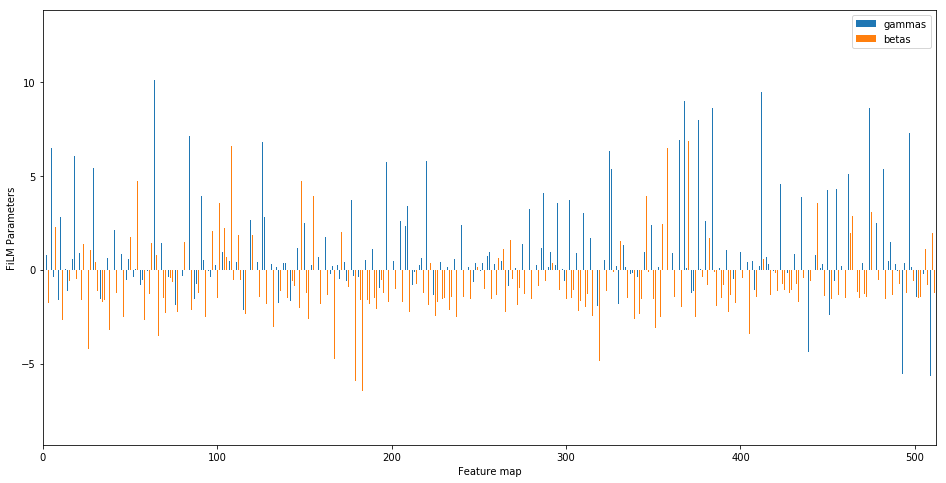

In [15]:
fig, ax = plt.subplots(figsize=(16, 8))
xs = np.asarray(
 [np.copy(data[SINGLE_EXAMPLE_KEY][key]) for key in ['gammas', 'betas']]
)
ax.set_xlim([0, xs.shape[-1]])
ax.set_xlabel('Feature map')
ax.set_ylabel('FiLM Parameters')
width = 0.2
offset = width
ind = np.arange(xs.shape[-1])
for i, (x, k) in enumerate(zip(xs, ['gammas', 'betas'])):
    ax.bar(ind + i * offset, x, width, label=k)
    _ = ax.legend()

__main__:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
__main__:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


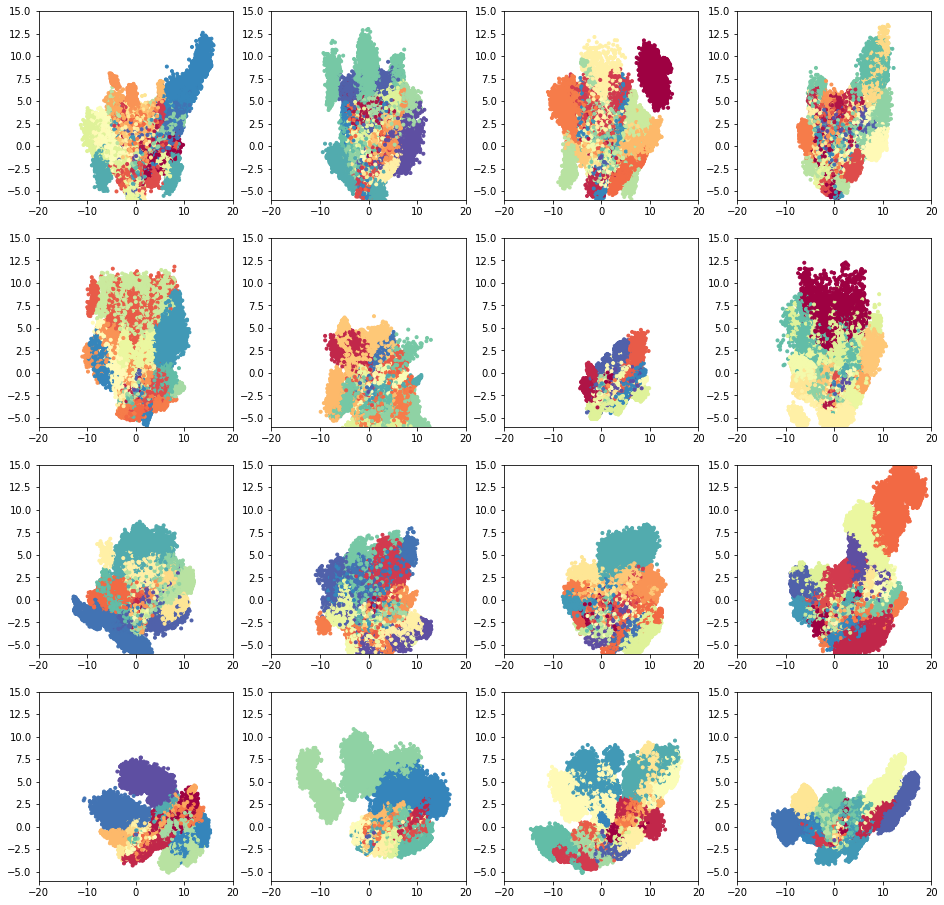

In [8]:
big_data = {}
for q_idx in range(len(q_feats['questions'][:10000])):
    question_encoded = q_feats['questions'][q_idx]
    question_encoded = torch.LongTensor(question_encoded).view(1, -1)
    question_encoded = question_encoded.type(dtype).long()
    question_var = Variable(question_encoded, volatile=False).to(device)
    
    img_idx = q_feats['image_idxs'][q_idx]
    features = torch.FloatTensor(img_feats['features'][img_idx]).unsqueeze(0)
    feats_var = Variable(features, volatile=False).to(device)
    sample = run_single_example(model, dtype, question_var, feats_var)
    big_data[(img_idx, q_idx)] = sample

fig, axes = plt.subplots(4, 4, figsize=(16,16))
KEYS = big_data.keys()
low, high = 0, 512

gammas = np.asarray(
 [np.copy(big_data[key]['gammas']) for key in KEYS]
)

betas = np.asarray(
 [np.copy(big_data[key]['betas']) for key in KEYS]
)

c = np.tile(np.arange(gammas.shape[1]), (gammas.shape[0], 1))

N = 512//16

for i, ax in enumerate(np.asarray(axes).ravel()):
    l = i * N
    h = (i + 1) * N
    ax.set_xlim([-20, 20])
    ax.set_ylim([-6, 15])
    scatter = ax.scatter(gammas[:, l:h], betas[:, l:h], c=c[:, l:h], marker='.', cmap='Spectral',
     norm=matplotlib.colors.Normalize(vmin=c[:, l:h].min(), vmax=c[:, l:h].max()))

In [ ]:
num_examples = 10000
KEYS = list(big_data.keys())[:num_examples]

gammas = np.asarray(
 [np.copy(big_data[key]['gammas']) for key in KEYS]
)

betas = np.asarray(
 [np.copy(big_data[key]['betas']) for key in KEYS]
)

c = np.tile(q_feats['question_families'][:num_examples], (512, 1)).T

for low in range(0, 512, 32):
    low, high = low, low + 32
    print(low, high)
    N = (high-low) // 32
    fig, axes = plt.subplots(4, 8, figsize=(16,16))

    for i, ax in enumerate(np.asarray(axes).ravel()):
        l = low + i * N
        h = low + (i + 1) * N
        ax.set_xlim([-20, 20])
        ax.set_ylim([-6, 15])
        scatter = ax.scatter(gammas[:, l:h], betas[:, l:h], c=c[:, l:h], marker='.', cmap='Spectral',
         norm=matplotlib.colors.Normalize(vmin=c[:, l:h].min(), vmax=c[:, l:h].max()))
    
    plt.show()

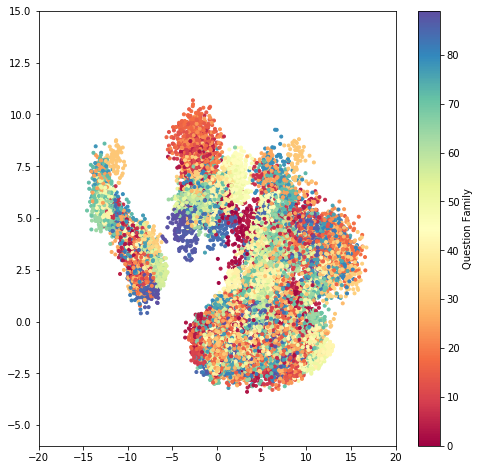

In [86]:
KEYS = list(big_data.keys())[:num_examples]
gammas = np.asarray(
 [np.copy(big_data[key]['gammas']) for key in KEYS]
)

betas = np.asarray(
 [np.copy(big_data[key]['betas']) for key in KEYS]
)

betas = np.asarray(
 [np.copy(big_data[key]['betas']) for key in KEYS]
)

feat_idx = np.tile(np.arange(gammas.shape[1]), (gammas.shape[0], 1))
q_family = np.tile(q_feats['question_families'][:num_examples], (512, 1)).T

fig, ax = plt.subplots(figsize=(8, 8))
l, h = 416, 417
c = q_family
mask = True #np.logical_or(q_family[:, l:h] > 40, False)

ax.set_xlim([-20, 20])
ax.set_ylim([-6, 15])
scatter = ax.scatter(gammas[:, l:h][mask], betas[:, l:h][mask], c=c[:, l:h][mask], marker='.', cmap='Spectral',
 norm=matplotlib.colors.Normalize(vmin=c[:, l:h].min(), vmax=c[:, l:h].max()))


colorbar = fig.colorbar(scatter, ax=ax)
colorbar.set_label("Question Family")

In [42]:
def save_data_to_h5(data):
    from collections import defaultdict
    datasets = defaultdict(list)

    for sample in data.values():
        for k, v in sample.items():
            datasets[k].append(v)


    import h5py
    keys = ['question', 'relu_norms', 'pre_film_norms', 'gammas', 'betas']
    with h5py.File('data/clevr_film_params.h5') as h:
        for k in keys:
            h.create_dataset(k, data=datasets[k])


#### What mechanism is used to switch off feature maps?

We want to test which parameter (gamma or beta) is used to inhibit the expression of certain feature maps. First, 

In [31]:
KEYS = QUESTION_KEYS

mask1 = np.asarray(
 [np.copy(data[key]['relu_norms']) for key in KEYS]
) == 0

mask2 = np.asarray(
 [np.copy(data[key]['pre_film_norms']) for key in KEYS]
) > 0

film_inhibited_feature_maps = np.logical_and(mask1, mask2)

print(f'# Post-FiLM zero norm feature maps {mask1.sum()}')
print(f'# Pre-ReLU non-zero norm feature maps {mask2.sum()}')
print(f'Intersection of (Pre-ReLU > 0) & (Post-ReLU == 0): {film_inhibited_feature_maps.sum()}')

# Post-FiLM zero norm feature maps 6939
# Pre-ReLU non-zero norm feature maps 53248
Intersection of (Pre-ReLU > 0) & (Post-ReLU == 0): 6939


All of the feature maps that vanish post-FiLM were non-zero before. This suggests that FiLM is sometimes used to switch feature maps off.

Let's investigate the mechanism through which it selects the feature maps to switch off:

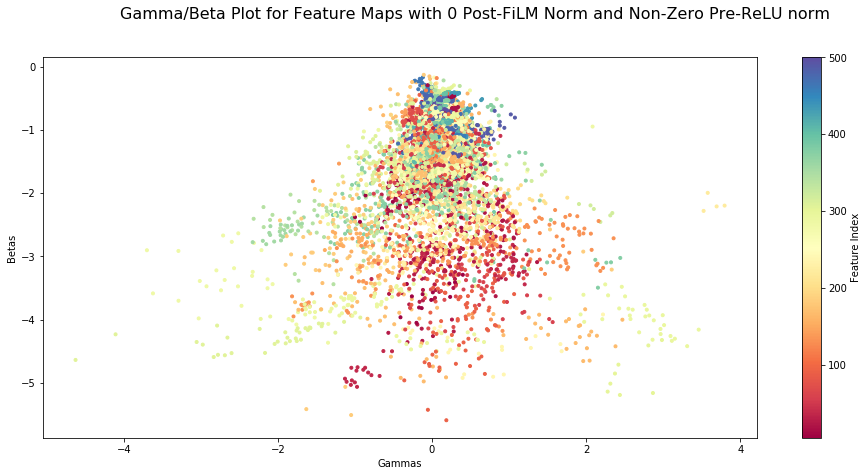

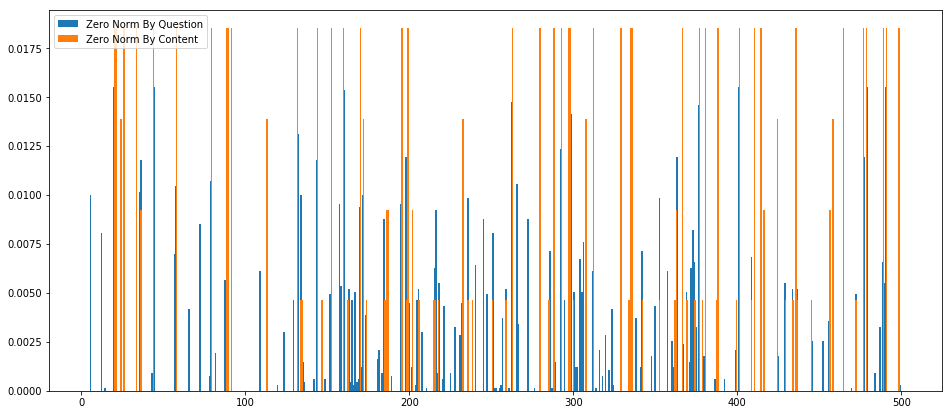

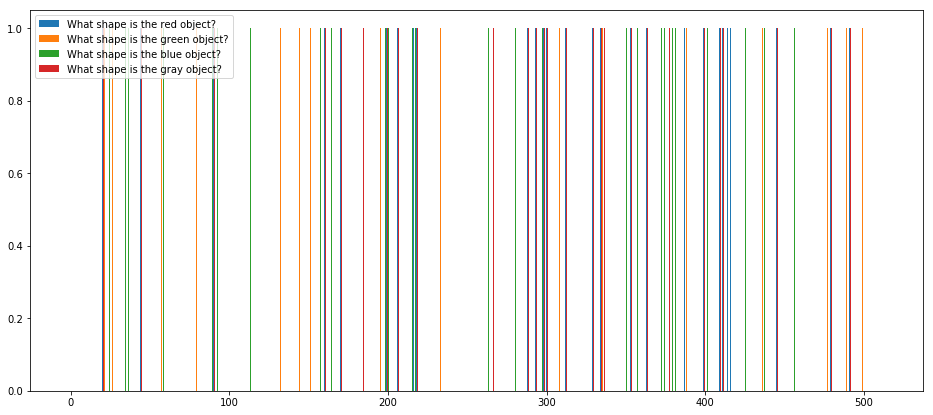

In [33]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.suptitle('Gamma/Beta Plot for Feature Maps with 0 Post-FiLM Norm and Non-Zero Pre-ReLU norm', fontsize=16)

gammas = np.asarray(
 [np.copy(data[key]['gammas']) for key in KEYS]
)

betas = np.asarray(
 [np.copy(data[key]['betas']) for key in KEYS]
)

zero_mask = film_inhibited_feature_maps
feat_idx = np.tile(np.arange(gammas.shape[1]), (gammas.shape[0], 1))

betas = betas[zero_mask]
gammas = gammas[zero_mask]
feat_idx = feat_idx[zero_mask]

c_values = [(feat_idx, 'Feature Index')]
for i, (c, label) in enumerate(c_values):
    ax.set_xlabel('Gammas')
    ax.set_ylabel('Betas')
    scatter = ax.scatter(gammas, betas, c=c, marker='.', cmap='Spectral', norm=matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max()))
    colorbar = fig.colorbar(scatter, ax=ax)
    colorbar.set_label(label)

# feat_idx = np.tile(np.arange(gammas.shape[1]), (gammas.shape[0], 1))
fig, ax = plt.subplots(figsize=(16, 7))
_ = ax.hist(np.where(zero_mask)[1], bins=512, density=True, label="Zero Norm By Question")

zero_norm_by_content = np.asarray(
 [np.copy(data[key]['relu_norms']) for key in CONTENT_KEYS]
) == 0
_ = ax.hist(np.where(zero_norm_by_content)[1], density=True, bins=512, label="Zero Norm By Content")
_ = ax.legend()

fig, ax = plt.subplots(figsize=(16, 7))
ind = np.arange(512)
for i, key in enumerate(QUESTION_KEYS_SMALL):
    x = np.copy(data[key]['relu_norms'])[:512] == 0
    _ = ax.bar(ind + i * offset, x, width, label=key[1])
_ = ax.legend()

In [53]:
mask.shape

(1000, 1)

#### How do Gamma/Beta vary with conditioning information?

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(16, 16))
num_filters = 512
ax = axes[0]
ax.set_xlim([0, num_filters])
ax.set_xlabel('Feature map')
ax.set_ylabel('$\gamma$')
width = 0.2
offset = width
ind = np.arange(num_filters)
for i, key in enumerate(QUESTION_KEYS_SMALL):
    x = np.copy(data[key]['gammas'])[:num_filters]
    _ = ax.bar(ind + i * offset, x, width, label=key[1])
_ = ax.legend()
ax = axes[1]
ax.set_xlim([0, num_filters])
ax.set_xlabel('Feature map')
ax.set_ylabel('$\\beta$')
width = 0.2
offset = width
ind = np.arange(num_filters)
for i, key in enumerate(QUESTION_KEYS_SMALL):
    x = np.copy(data[key]['betas'])[:num_filters]
    _ = ax.bar(ind + i * offset, x, width, label=key[1])
_ = ax.legend()

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(16, 16))
ax = axes[0]
ax.set_xlim([64, 96])
ax.set_xlabel('Feature map')
ax.set_ylabel('Centered $|\gamma|$')
width = 0.2
offset = width
ind = np.arange(64, 96)
xs = np.asarray(
 [np.copy(data[key]['gammas'])[64:96] for key in QUESTION_KEYS_SMALL]
).reshape((4, -1))
xs = xs - xs.mean(axis=0, keepdims=True)
for i, (x, style_name) in enumerate(zip(xs, QUESTIONS_SMALL)):
    ax.bar(ind + i * offset, x, width, label=style_name)
_ = ax.legend()
ax = axes[1]
ax.set_xlim([64, 96])
ax.set_xlabel('Feature map')
ax.set_ylabel('Centered $|\\beta|$')
width = 0.2
offset = width
ind = np.arange(64, 96)
xs = np.asarray(
 [np.copy(data[key]['betas'])[64:96] for key in QUESTION_KEYS_SMALL]
).reshape((4, -1))
xs = xs - xs.mean(axis=0, keepdims=True)
for i, (x, style_name) in enumerate(zip(xs, QUESTIONS_SMALL)):
    ax.bar(ind + i * offset, x, width, label=style_name)
_ = ax.legend()

### Scatterplots

ValueError: c of shape (16, 3328) not acceptable as a color sequence for x with size 13312, y with size 13312

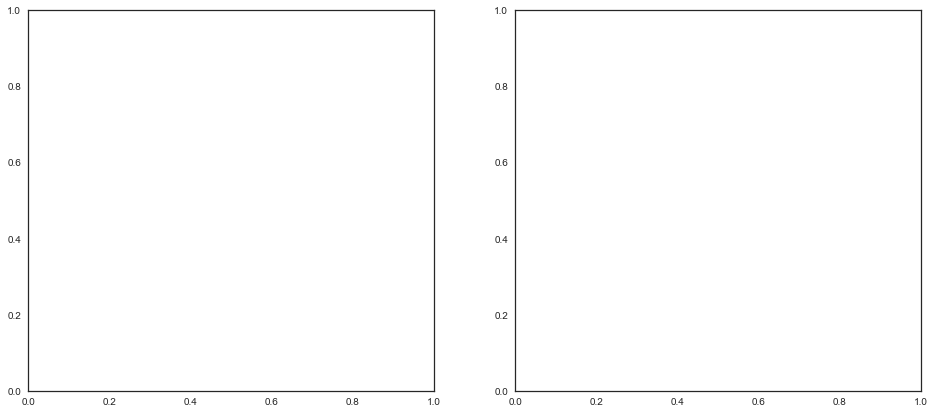

In [183]:
gammas = np.asarray(
 [np.copy(data[key]['gammas'][:128]) for key in QUESTION_KEYS]
).reshape((16, -1))
betas = np.asarray(
 [np.copy(data[key]['betas'[:128]]) for key in QUESTION_KEYS]
).reshape((16, -1))
norms = np.asarray(
 [np.copy(data[key]['relu_norms'][:128]) for key in ALL_KEYS]
).reshape((4, 16, -1)).mean(axis=0)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
ax = axes[0]
val = max(betas.min(), betas.max())
scatter = ax.scatter(gammas, norms, c=betas, marker='.', cmap='Spectral',
 norm=matplotlib.colors.Normalize(vmin=-val, vmax=val))
ax.set_xlabel('Centered $|\gamma|$')
ax.set_ylabel('Centered post-ReLU feature map norm')
colorbar = fig.colorbar(scatter, ax=ax)
colorbar.set_label('Centered $|\\beta|$')
ax = axes[1]
val = max(gammas.min(), gammas.max())
scatter = ax.scatter(betas, norms, c=gammas, marker='.', cmap='Spectral',
 norm=matplotlib.colors.Normalize(vmin=-val, vmax=val))
ax.set_xlabel('Centered $|\\beta|$')
ax.set_ylabel('Centered post-ReLU feature map norm')
colorbar = fig.colorbar(scatter, ax=ax)
colorbar.set_label('Centered $|\gamma|$')

### Exploring Activations

In [48]:
import numpy.ma as ma
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
grads = {}
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    im_shape = imgs.shape
    imgs = imgs.reshape(-1, im_shape[1], im_shape[2])
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in np.arange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around plt.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im, cax=cax)

def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

def visualize_example(model, dtype, question_raw, feats_var):
    vocab = utils.load_cpu('models/best.pt')['vocab']
    question_var = tokenize_question(vocab, question_raw) 
    # Run the model
    scores = None
    predicted_program = None
    pg, ee = model
    pg.type(dtype)
    pg.eval()
    ee.type(dtype)
    ee.eval()
    predicted_program = pg(question_var)
    scores = ee(feats_var, predicted_program, save_activations=True)

    # Print results
    predicted_probs = scores.data.cpu()
    _, predicted_answer_idx = predicted_probs[0].max(dim=0)
    predicted_probs = F.softmax(Variable(predicted_probs[0])).data
    predicted_answer = vocab['answer_idx_to_token'][predicted_answer_idx.item()]

    answers_to_probs = {}
    for i in range(len(vocab['answer_idx_to_token'])):
        answers_to_probs[vocab['answer_idx_to_token'][i]] = predicted_probs[i]
        answers_to_probs_sorted = sorted(answers_to_probs.items(), key=lambda x: x[1])
        answers_to_probs_sorted.reverse()

    gammas, betas = torch.split(predicted_program[:,:,:2*128], 128, dim=-1)
    relu_out, pre_out = zip(*ee.module_outputs)
    relu_out, pre_out = torch.stack(relu_out), torch.stack(pre_out)
    relu_norms = get_norms(relu_out)
    pre_relu_norms = get_norms(pre_out)

    # Get gradients
    for i in range(ee.num_modules):
        ee.module_outputs[i][1].register_hook(save_grad('m' + str(i)))
    
    probs = F.softmax(scores[0])
    entropy = -(probs * probs.log()).sum()
    entropy.backward()
    module_grads = torch.stack([grads['m' + str(i)] for i in range(4)], dim=1)
    module_grad_norms = get_norms(module_grads)
    data = {
        'question': question_raw,
        'answer': predicted_answer,
        'pre_film_out': pre_out.detach().numpy(),
        'post_film_out': relu_out.detach().numpy(),
        'relu_norms': relu_norms.data.numpy().flatten(),
        'grads': module_grads.detach().numpy(),
        'grad_norms': module_grad_norms.detach().numpy(),
        'pre_relu_norms': pre_relu_norms.data.numpy().flatten(),
        'gammas': gammas.data.numpy().flatten(),
        'betas': betas.data.numpy().flatten(),
    }
    return data

In [49]:
content_img = "img/CLEVR_val_000013.png"
feats_var = extract_image_features(cnn, content_img).detach()
questions = ["How many objects are there?", "What color is the sphere?", "Is there a cylinder?", "What material is the cube?", "Are there more cylinders than metallic cubes?"]
samples = [ visualize_example(model, dtype, q, feats_var) for q in questions ]

Extracting image features...


__main__:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
__main__:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
__main__:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
__main__:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
cmap = cm.viridis
for s in samples:
    plt.figure(figsize=(20, 20), dpi=196)
    features = s['grads'].squeeze()[0]
    nice_imshow(plt.gca(), make_mosaic(features[:, :, :, None], 8, 16), cmap=cmap)
    plt.show()

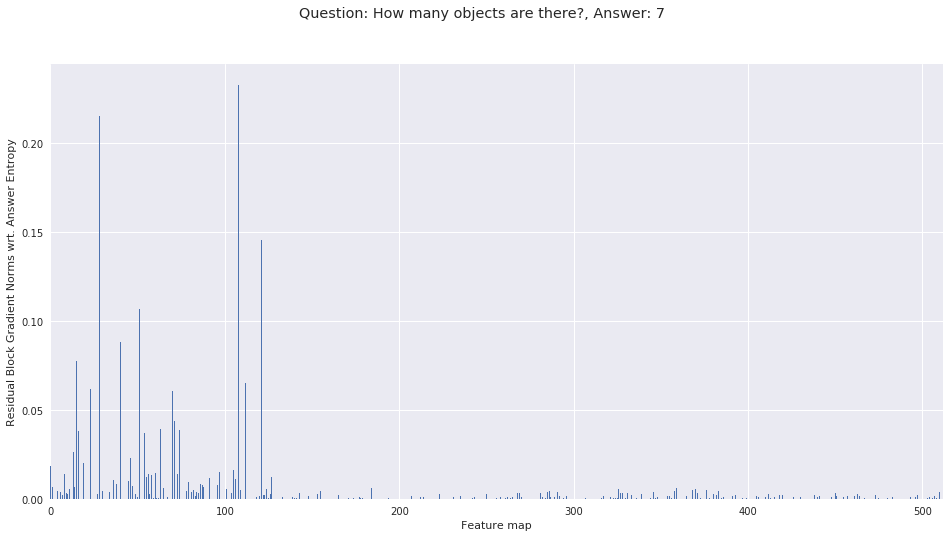

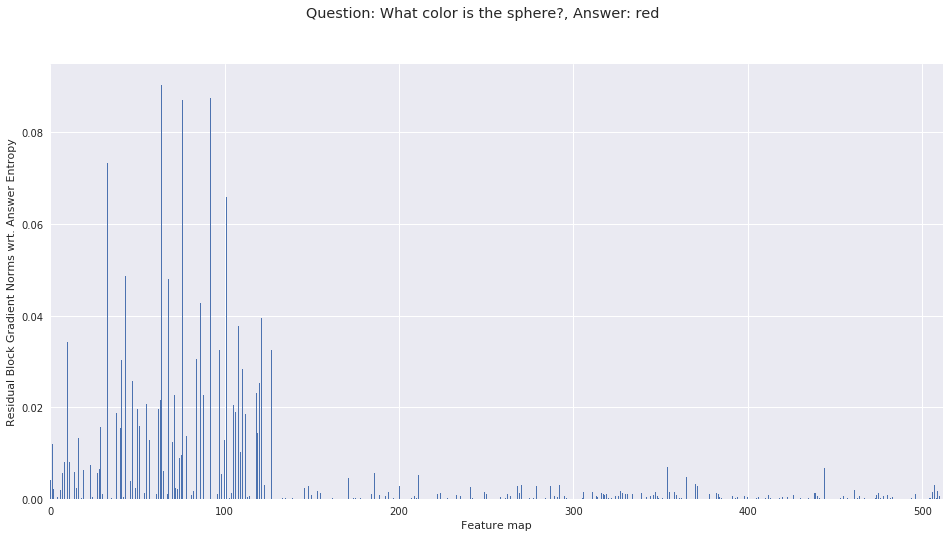

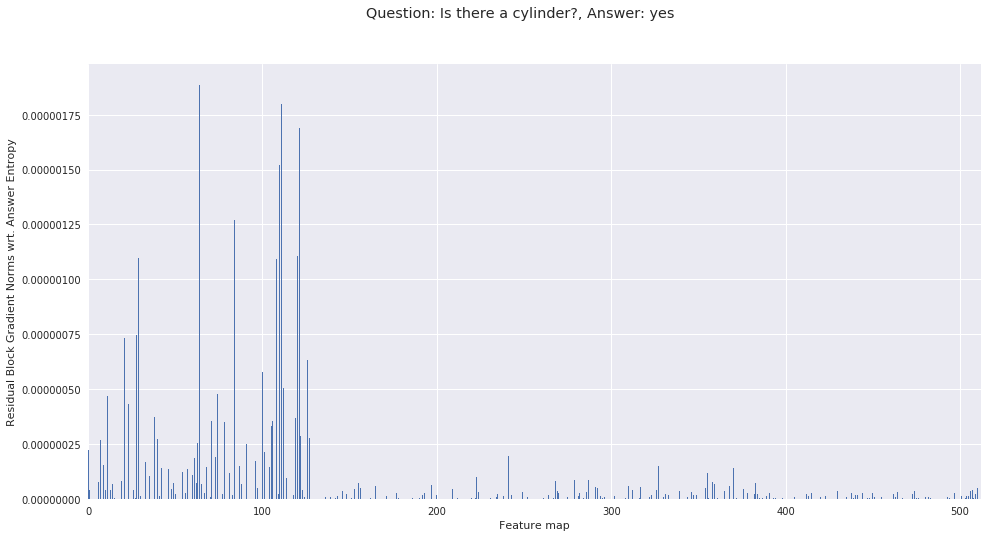

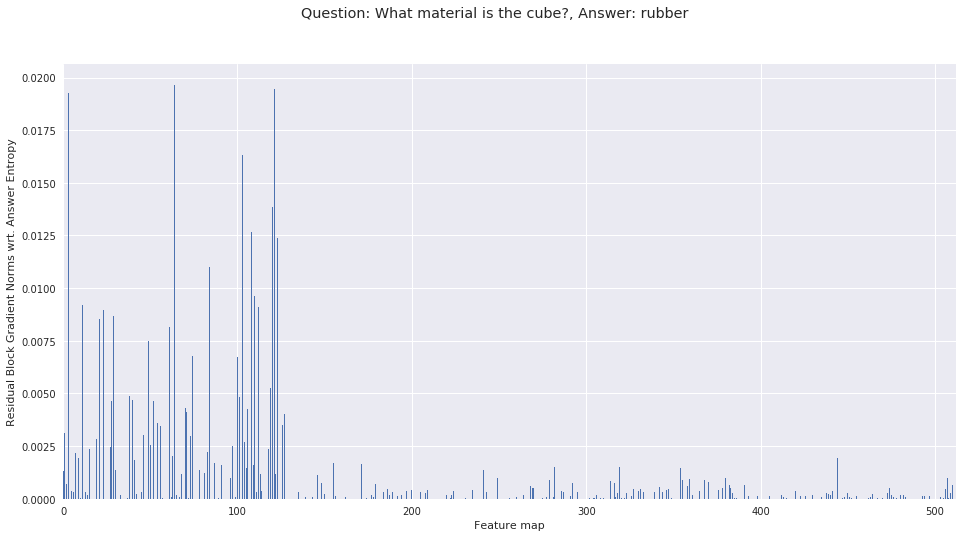

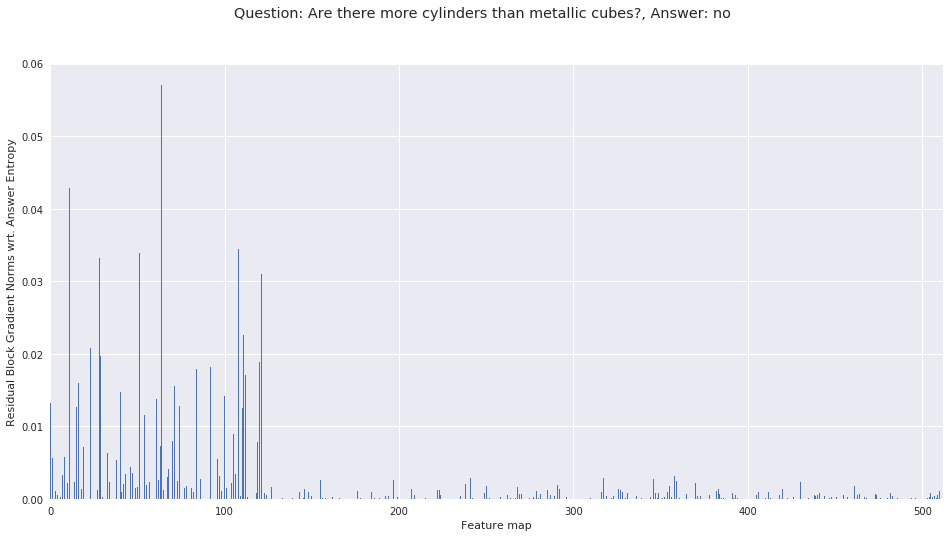

In [51]:
for s in samples:
    
    x = np.copy(s['grad_norms']).flatten()
    ind = np.arange(len(x))
    width = 0.5
    fig, ax = plt.subplots(figsize=(16, 8))
    q, a = s['question'], s['answer']
    plt.suptitle(f"Question: {q}, Answer: {a}")
    ax.bar(ind, x, width)
    ax.set_xlim([0, len(x)])
    ax.set_xlabel('Feature map')
    _ = ax.set_ylabel('Residual Block Gradient Norms wrt. Answer Entropy')